In [1]:
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2

## Install package within conda using tensorflow
## /opt/homebrew/Caskroom/miniconda/base/envs/capstone_2/bin/pip install tensorflow

In [2]:
fc = Fishnet.load("../Gis/Fishnet/fishnet_quarter_mile_completed.pkl")

In [3]:
# Compute Urbanization Rate
# for year in [2017, 2018, 2019, 2020, 2021, 2022]:
#     fc.compute_difference(f'MeanPixel_{year}', f'MeanPixel_{year-1}', filtered=True, normalize = True)

vars = ["id", "batch_id", "MeanPixel_2016", "MeanPixel_2017", "MeanPixel_2018", "MeanPixel_2019", "MeanPixel_2020", "MeanPixel_2021", "MeanPixel_2022"]
data = fc.filtered_fishnet[vars]
data.rename(columns={"id": "tile_id"}, inplace=True)
data["tile_id"] = data["tile_id"].astype(int)
data["batch_id"] = data["batch_id"].astype(int)

# Pivot wide to long
data = data.melt(id_vars=["tile_id", "batch_id"], var_name="year", value_name="urbanization")
data["urbanization"] = data["urbanization"] / 255 #normalization
data["year"] = data["year"].str[-4:]
data.head()

# data.to_csv('../Results/urbanization.csv', index=False)

,tile_id,batch_id,year,urbanization
0,6060154,23743,2016,0.710556
1,6060155,23743,2016,0.802841
2,6060156,23743,2016,0.550000
3,6060157,23743,2016,0.447222
4,6060158,23743,2016,0.773333


In [4]:
#compute rows and cols in Fishnet
dc = fc.filtered_fishnet.copy()
L = dc["geometry"].bounds["maxx"].max() - dc["geometry"].bounds["minx"].min()
H = dc["geometry"].bounds["maxy"].max() - dc["geometry"].bounds["miny"].min()

rows = int(H / fc.tile_height_degrees)
cols = int(L / fc.tile_width_degrees)
print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 117, Number of columns: 193


In [21]:
# Generate tensor
years = ["2016", "2017", "2018", "2019", "2020", "2021", "2022"]
tensor = np.zeros((len(years), rows, cols, 1))

for yr in tqdm(years):
    tensor[years.index(yr), :, :, 0] = data[data["year"]== yr]["urbanization"].to_numpy().reshape(rows, cols)

100%|██████████| 7/7 [00:00<00:00, 175.50it/s]


In [22]:
tensor.shape

(7, 117, 193, 1)

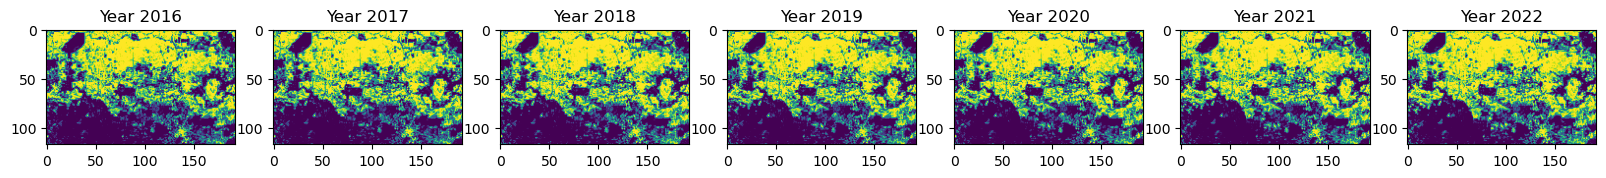

In [23]:
# plot consecutively to see the change
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(tensor[i, :, :, 0])
    ax[i].set_title(f"Year {years[i]}")

# Now, we need to generate the dataset.

We need a data loader. We need to generate a dataset of that dimension:
(NBR_SAMPLE, TIME_SEQ, IMG_WIDTH, IMG_HEIGHT, CHANNELS)

@TODO:

1. Define proper loss function for the neural network (MSE)
2. Check which frames are used for training
3. ✅ Add TensorBoard
3.5. Add TensorBoard on Colab
4. Brainstorm the architecture
5. ✅ Start training from a pre-trained network
6. Compare frequence of de-urbanization to urbanization
7. Try to apply the video prediction framework on the urbanization RATE (not on urbanization to have an easier metric)
8. Create an artificial dataset to see how the model evolve
9. Export a bigger dataset (whole Texas Region)

In [304]:
def extract_submatrix(matrix, length, slide_size):
    submatrices = []
    rows, cols = matrix.shape
    for i in range(0, rows - (length - 1), slide_size):
        for j in range(0, cols - (length - 1), slide_size):
            submatrix = matrix[i:i+length, j:j+length]
            submatrices.append(submatrix)
    return np.array(submatrices)

def generate_submatrices(tensor, years, length, slide_size):
    submatrices = []
    for i, yr in enumerate(years):
        mat = tensor[i, :, :, 0]
        submatrices.append(extract_submatrix(mat, length, slide_size))
    submatrices = np.array(submatrices)
    print(np.array(submatrices).shape)
    transposed_array = np.transpose(submatrices, (1, 0, 2, 3))
    reshaped_array = transposed_array.reshape((-1, 7, length, length, 1))
    return reshaped_array

In [305]:
TIME_SEQ = 7  # frames
IMG_SIZE = 15  # tiles
SLIDE_WDW = 5 # tiles

sub_matrices = generate_submatrices(tensor, years, IMG_SIZE, SLIDE_WDW)
sub_matrices.shape

(7, 756, 15, 15)


(756, 7, 15, 15, 1)

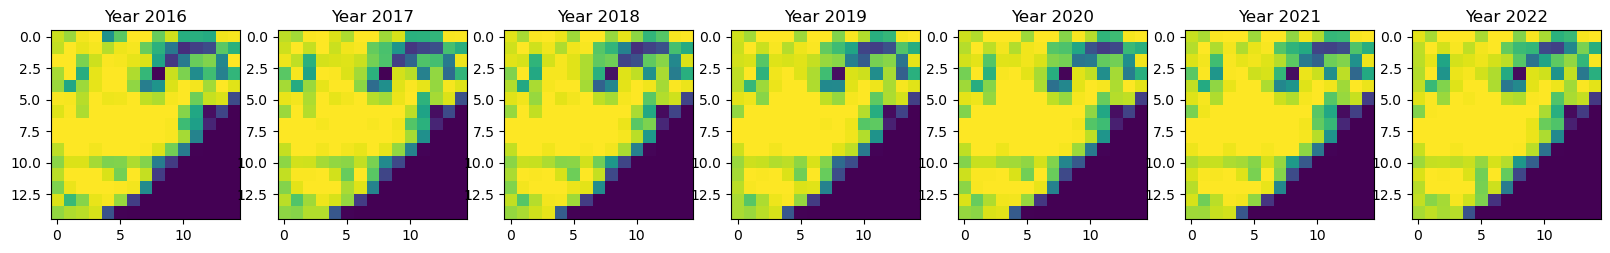

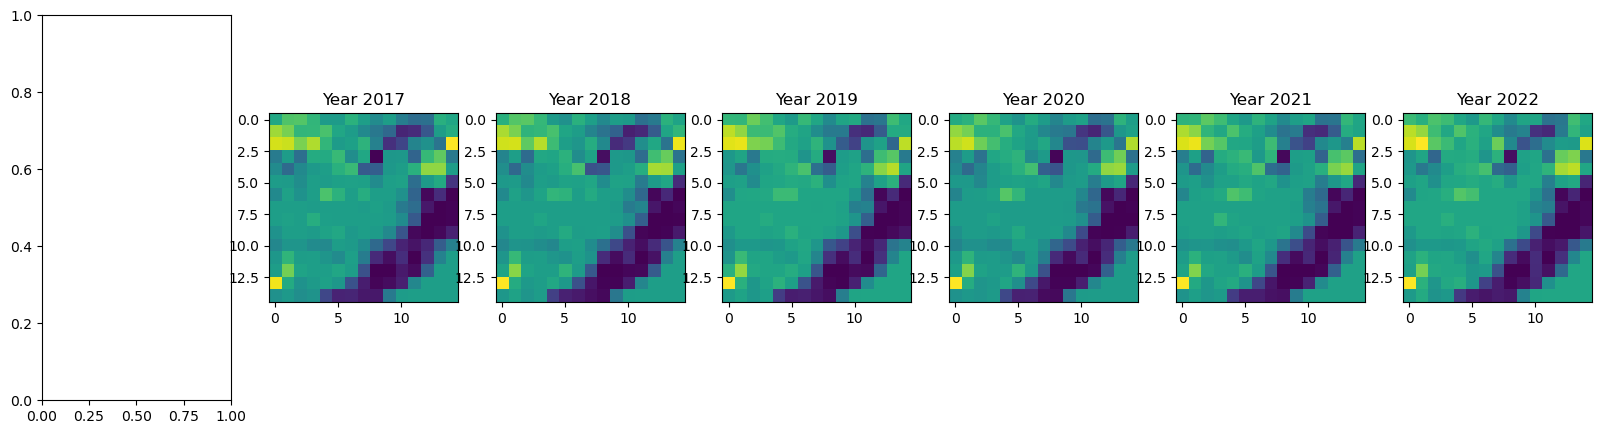

In [306]:
sub_matrices[1].shape

# plot all these images on 7 plots
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(sub_matrices[3][i, :, :, 0])
    ax[i].set_title(f"Year {years[i]}")

# plot all these images on 7 plots
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(1, 7):
    ax[i].imshow(sub_matrices[3][i, :, :, 0] - sub_matrices[2][i, :, :, 0])
    ax[i].set_title(f"Year {years[i]}")

# Applying Keras' Tutorial Function to finish dataset generation

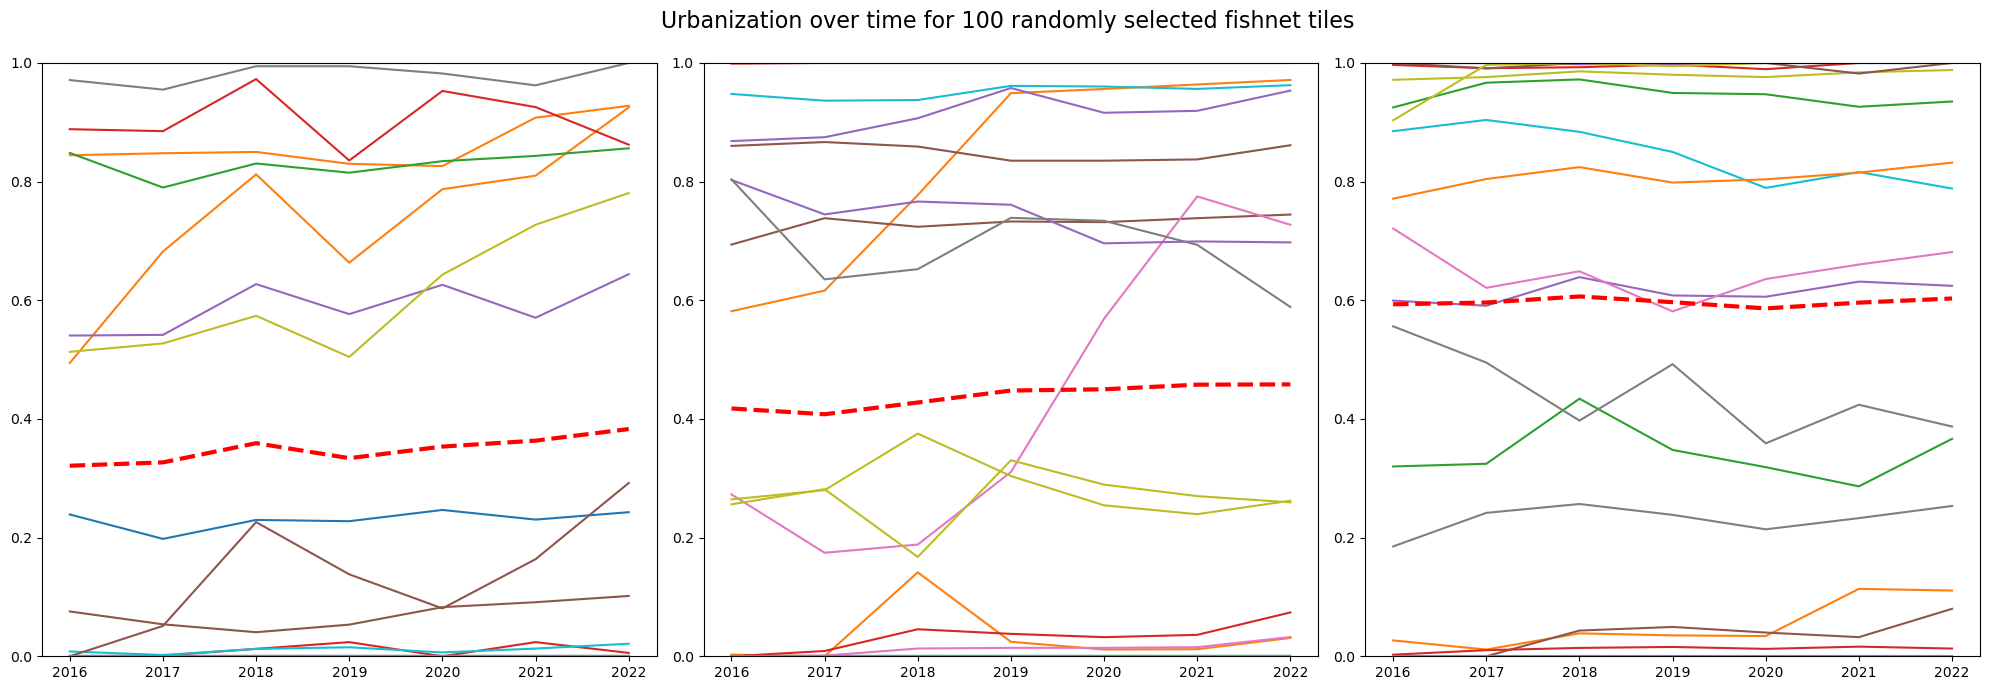

In [283]:
# Plot the yearly urbanization for 100 different tile_ids randomly selected
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
for subplot in ax:
    for _ in range(20):
        tile_id = np.random.choice(data["tile_id"].unique())
        subplot.plot(data[data["tile_id"]==tile_id]["year"], data[data["tile_id"]==tile_id]["urbanization"])
        subplot.set_ylim([0, 1])
        # subplot.set_xticks([])
        # subplot.set_yticks([])
        # subplot.legend([])

    # title for the whole
    ax[1].set_title("Urbanization over time for 100 randomly selected fishnet tiles \n", fontsize=16, loc="center")

    # Calculate and plot the average line
    avg_line = np.mean([line.get_ydata() for line in subplot.lines], axis=0)
    subplot.plot(data[data["tile_id"]==tile_id]["year"], avg_line, color="red", linestyle="--", label="Average", linewidth=3)

# plt.title("Urbanization over time for 100 randomly selected fishnet tiles", fontsize=16, loc="left")
plt.tight_layout()
plt.show()


In [307]:
dataset = sub_matrices

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def generate_shited_frames(data, type):
    shape = data.shape
    if type == "train":
        x_1 = data[:, 0 : 4, :, :]
        y_1 = data[:, 4, :, :]
        x_2 = data[:, 1 : 5, :, :]
        y_2 = data[:, 5, :, :]
        x = np.concatenate((x_1, x_2))
        y = np.concatenate((y_1, y_2)).reshape((data.shape[0]*2,1, data.shape[2], data.shape[3], data.shape[4]))
    elif type == "validation":
        x = data[:, 2 : 6, :, :]
        y = data[:, 6, :, :].reshape(data.shape[0],1, data.shape[2], data.shape[3], data.shape[4])
    else:
        raise ValueError("Type must be train or validation")
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = generate_shited_frames(dataset, "train")
x_val, y_val = generate_shited_frames(dataset, "validation")

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (1512, 4, 15, 15, 1), (1512, 1, 15, 15, 1)
Validation Dataset Shapes: (756, 4, 15, 15, 1), (756, 1, 15, 15, 1)


Displaying frames for example 377.


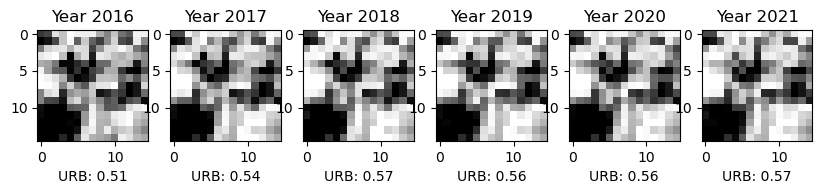

In [309]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 6, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Year {years[idx]}")
    # ax.axis("off")
    ax.set_xlabel(f"URB: {np.mean(dataset[data_choice][idx]):.2f}")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [286]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import datetime

In [316]:
def create_model():
    # Construct the input layer with 4 time frames in input
    inp = layers.Input(shape=(4, *x_train.shape[2:]))

    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    # followed by a `Conv3D` layer for the spatiotemporal outputs.
    x = layers.ConvLSTM2D(
        filters=64,                # transform each image into a 64 channel image 
        kernel_size=(3, 3),        # each image [7,7] --> [5,5] (with 64 channels, see above, filters)
        padding="same",           # valid: no padding (so image stays [5,5], same: padding so image stays [6x6])
        return_sequences=True,
        activation="relu",
    )(inp)
    x = layers.BatchNormalization()(x)   # improve the training speed, stability, and generalization of the network
    x = layers.ConvLSTM2D(
        filters=64,                      # 
        kernel_size=(3, 3),              # each previous [5,5] image --> [3,3] image
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=False,
        activation="relu",
    )(x)
    x = layers.Conv2D(
        filters=1,               # 1 filter leads to one chanel in the output
        kernel_size=(3, 3),   # 
        activation="sigmoid", 
        padding="same"
    )(x)

    # Next, we will build the complete model and compile it.
    model = keras.models.Model(inp, x)
    # model.compile(
    #     loss=keras.losses.MeanSquaredError, optimizer=keras.optimizers.legacy.Adam(),
    # )
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
    return model

# Train the model from scratch
model = create_model()

# Use a pretrained model from HuggingFace (https://huggingface.co/keras-io/conv-lstm)
# model_path = "./pretrained-models/"
# model = tf.keras.models.load_model(model_path)

In [300]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Training the model

In [291]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
%rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [267]:
# command to kill tensorboard process on port 6006: kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
# Run TensorBoard
%reload_ext tensorboard
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 44957), started 1 day, 1:47:05 ago. (Use '!kill 44957' to kill it.)

In [317]:
# Set tensorboard Callback
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 64

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback],#early_stopping, reduce_lr],
)

Epoch 1/20
24/24 [==============================] - 18s 621ms/step - loss: 0.1086 - val_loss: 0.1629
Epoch 2/20
24/24 [==============================] - 14s 575ms/step - loss: 0.0989 - val_loss: 0.1624
Epoch 3/20
24/24 [==============================] - 14s 581ms/step - loss: 0.0953 - val_loss: 0.1613
Epoch 4/20
24/24 [==============================] - 15s 620ms/step - loss: 0.0925 - val_loss: 0.1604
Epoch 5/20
24/24 [==============================] - 16s 652ms/step - loss: 0.0901 - val_loss: 0.1600
Epoch 6/20
24/24 [==============================] - 15s 607ms/step - loss: 0.0885 - val_loss: 0.1596
Epoch 7/20
24/24 [==============================] - 14s 576ms/step - loss: 0.0877 - val_loss: 0.1588
Epoch 8/20
24/24 [==============================] - 15s 616ms/step - loss: 0.0868 - val_loss: 0.1587
Epoch 9/20
24/24 [==============================] - 15s 615ms/step - loss: 0.0863 - val_loss: 0.1586
Epoch 10/20
24/24 [==============================] - 15s 606ms/step - loss: 0.0854 - val_lo

In [319]:
x_train.shape

(1512, 4, 15, 15, 1)

In [321]:
y_train.shape

(1512, 1, 15, 15, 1)

# Analyze the results

Let's work on one tile. Let's assume that we predict the next urbanization rate of that specific tile.

1. Compute total R2 for that prediction ?

In [322]:
# predict the values of the test set using keras
y_pred = model.predict(x_val)

24/24 [==============================] - 3s 101ms/step


In [323]:
y_pred.shape

(756, 15, 15, 1)

In [325]:
y_val.shape

(756, 1, 15, 15, 1)

In [328]:
# flatten the y tensors
y_pred_flat = y_pred.flatten()
y_val_flat = y_val.flatten()

# compute the R^2
from sklearn.metrics import r2_score

r2_score(y_val_flat, y_pred_flat)

0.23765140204826662

In [151]:
np.sqrt(0.0015)

# 0.038

0.03872983346207417

In [269]:
data.groupby('year').mean()

,tile_id,batch_id,urbanization
year,,,
2016,6249852.0,24562.084717,0.461611
2017,6249852.0,24562.084717,0.470271
2018,6249852.0,24562.084717,0.489959
2019,6249852.0,24562.084717,0.489318
2020,6249852.0,24562.084717,0.492546
2021,6249852.0,24562.084717,0.499365
2022,6249852.0,24562.084717,0.516641


In [153]:
0.038 / 0.46161

0.08232057364441844

In [161]:
# pivot long to wide for data
data_wide = data.pivot_table(index=['tile_id', 'batch_id'], columns='year', values='urbanization')

print((data_wide['2016'] - data_wide['2017']).mean())
print((data_wide['2016'] - data_wide['2017']).median())
print((data_wide['2016'] - data_wide['2017']).std())

-0.008659843465279668
0.0
0.061394861436861695


In [145]:
data.groupby('year').std()

,tile_id,batch_id,urbanization
year,,,
2016,110408.870678,435.457049,0.401121
2017,110408.870678,435.457049,0.403521
2018,110408.870678,435.457049,0.405081
2019,110408.870678,435.457049,0.403838
2020,110408.870678,435.457049,0.404390
2021,110408.870678,435.457049,0.404287
2022,110408.870678,435.457049,0.405017


<Axes: >

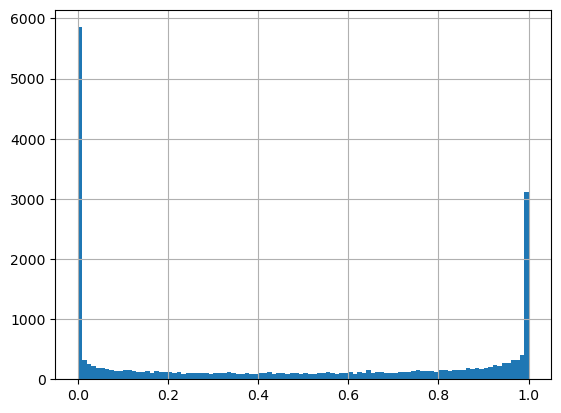

In [149]:
# plot urbanization rate for 2016
data[data['year'] == '2016']['urbanization'].hist(bins=100)